In [1]:
from tensorflow.keras.utils import Sequence
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import math

class DatasetSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, augmentations):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]

        return np.stack([
            self.augment(image=x)["image"] for x in batch_x
        ], axis=0), np.array(batch_y)

In [2]:
import glob
import os
import cv2

import numpy as np

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from albumentations import (
    Compose, HorizontalFlip
)


def get_images(list_images, type_image):
    # Read the images
    array_imgs = []
    for name in list_images:
        img = cv2.imread(name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if type_image == 'cropped':
            img = img[240:480, 0:640]
        img = cv2.resize(img, (int(img.shape[1] / 4), int(img.shape[0] / 4)))
        array_imgs.append(img)

    return array_imgs

def parse_json(data):
    # Process json
    array_annotations_v = []
    array_annotations_w = []
    array = []
    data_parse = data.split('}')[:-1]

    for number, d in enumerate(data_parse):
        v = d.split('"v": ')[1]
        d_parse = d.split(', "v":')[0]
        w = d_parse.split(('"w": '))[1]
        array_annotations_v.append(float(v))
        array_annotations_w.append(float(w))
        array.append((float(v), float(w)))
    '''    
    # START NORMALIZE DATA
    array_annotations_v = np.stack(array_annotations_v, axis=0)
    array_annotations_v = array_annotations_v.reshape(-1, 1)

    array_annotations_w = np.stack(array_annotations_w, axis=0)
    array_annotations_w = array_annotations_w.reshape(-1, 1)

    normalized_X = normalize(array_annotations_v)
    normalized_Y = normalize(array_annotations_w)

    normalized_annotations = []
    for i in range(0, len(normalized_X)):
        normalized_annotations.append([normalized_X.item(i), normalized_Y.item(i)])

    return normalized_annotations
    '''
    return array

def flip_images(images, array_annotations):
    FLIP_AUGMENTATION = Compose([
        HorizontalFlip(),
    ])
    
    flipped_images = []
    flipped_annotations = []
    for i, image in enumerate(images):
        flipped_images.append(cv2.flip(image, 1))
        flipped_annotations.append((array_annotations[i][0], -array_annotations[i][1]))
        #flipped_image = FLIP_AUGMENTATION(image=image)['image']
        #flipped_images.append(flipped_image)
        #flipped_annotations.append([array_annotations[i][0], 1-array_annotations[i][1]])
    
    images += flipped_images
    array_annotations += flipped_annotations
    return images, array_annotations


def add_extreme_data(images, array_annotations):
    for i in range(0, len(array_annotations)):
        if abs(array_annotations[i][1]) >= 1:
            if abs(array_annotations[i][1]) >= 2:
                num_iter = 10
            else:
                num_iter = 5
            for j in range(0, num_iter):
                array_annotations.append(array_annotations[i])
                images.append(images[i])
        if float(array_annotations[i][0]) <= 2:
            for j in range(0, 1):
                array_annotations.append(array_annotations[i])
                images.append(images[i])
    return images, array_annotations

def normalize(x):
    x = np.asarray(x)
    return (x - x.min()) / (np.ptp(x))

print('---- Complete ----')
complete_name_file = 'complete_dataset/data.json'
complete_file = open(complete_name_file, 'r')
data_complete = complete_file.read()
complete_file.close()

array_annotations_complete = []
DIR_complete_images = 'complete_dataset/Images/'
list_images_complete = glob.glob(DIR_complete_images + '*')
images_paths_complete = sorted(list_images_complete, key=lambda x: int(x.split('/')[2].split('.png')[0]))
#print(images_paths_complete)
array_annotations_complete = parse_json(data_complete)

images_complete = get_images(images_paths_complete, 'cropped')
images_complete, array_annotations_complete = flip_images(images_complete, array_annotations_complete)
print(len(images_complete))
print(type(images_complete))
print(len(array_annotations_complete))
images_complete, array_annotations_complete = add_extreme_data(images_complete, array_annotations_complete)
print(len(images_complete))
print(type(images_complete))
print(len(array_annotations_complete))

array_annotations_v = []
array_annotations_w = []
for annotation in array_annotations_complete:
    array_annotations_v.append(annotation[0])
    array_annotations_w.append(annotation[1])
    
# START NORMALIZE DATA
array_annotations_v = np.stack(array_annotations_v, axis=0)
array_annotations_v = array_annotations_v.reshape(-1, 1)

array_annotations_w = np.stack(array_annotations_w, axis=0)
array_annotations_w = array_annotations_w.reshape(-1, 1)

normalized_X = normalize(array_annotations_v)
normalized_Y = normalize(array_annotations_w)

normalized_annotations = []
for i in range(0, len(normalized_X)):
    normalized_annotations.append([normalized_X.item(i), normalized_Y.item(i)])
    
array_annotations_complete = normalized_annotations

print(len(images_complete))
print(type(images_complete))
print(len(array_annotations_complete))


print('---- Curves ----')
curves_name_file = 'curves_only/data.json'
file_curves = open(curves_name_file, 'r')
data_curves = file_curves.read()
file_curves.close()

DIR_curves_images = 'curves_only/Images/'
list_images_curves = glob.glob(DIR_curves_images + '*')
images_paths_curves = sorted(list_images_curves, key=lambda x: int(x.split('/')[2].split('.png')[0]))
array_annotations_curves = parse_json(data_curves)

images_curves = get_images(images_paths_curves, 'cropped')
images_curves, array_annotations_curves = flip_images(images_curves, array_annotations_curves)
print(len(images_curves))
print(type(images_curves))
print(len(array_annotations_curves))
images_curves, array_annotations_curves = add_extreme_data(images_curves, array_annotations_curves)
print(len(images_curves))
print(type(images_curves))
print(len(array_annotations_curves))

array_annotations_v = []
array_annotations_w = []
for annotation in array_annotations_curves:
    array_annotations_v.append(annotation[0])
    array_annotations_w.append(annotation[1])
    
# START NORMALIZE DATA
array_annotations_v = np.stack(array_annotations_v, axis=0)
array_annotations_v = array_annotations_v.reshape(-1, 1)

array_annotations_w = np.stack(array_annotations_w, axis=0)
array_annotations_w = array_annotations_w.reshape(-1, 1)

normalized_X = normalize(array_annotations_v)
normalized_Y = normalize(array_annotations_w)

normalized_annotations = []
for i in range(0, len(normalized_X)):
    normalized_annotations.append([normalized_X.item(i), normalized_Y.item(i)])
    
array_annotations_curves = normalized_annotations

print(len(images_curves))
print(type(images_curves))
print(len(array_annotations_curves))

---- Complete ----
34682
<class 'list'>
34682
55346
<class 'list'>
55346
55346
<class 'list'>
55346
---- Curves ----
10536
<class 'list'>
10536
12758
<class 'list'>
12758
12758
<class 'list'>
12758


--- COMPLETE DATA ---


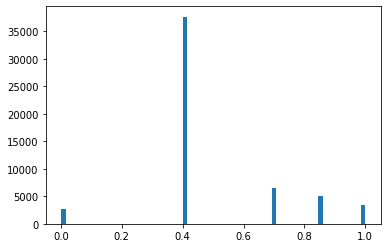

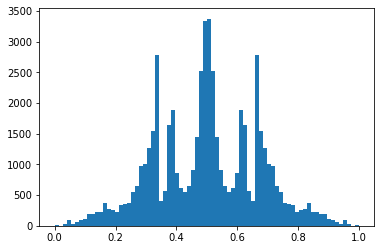

--- CURVES DATA ---


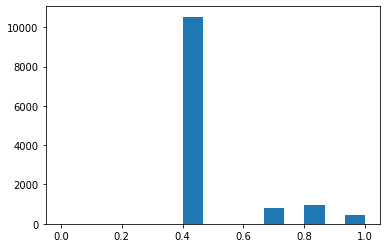

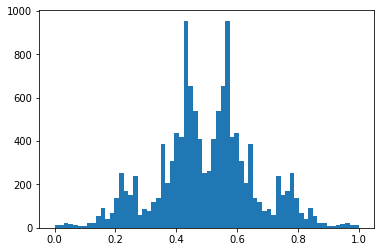

In [5]:
print('--- COMPLETE DATA ---')
ann_x = []
ann_y = []
for ann in array_annotations_complete:
    ann_x.append(ann[0])
    ann_y.append(ann[1])

n, bins, patches = plt.hist(x=ann_x, bins='auto')
plt.show()
n, bins, patches = plt.hist(x=ann_y, bins='auto')
plt.show()

print('--- CURVES DATA ---')
ann_x = []
ann_y = []
for ann in array_annotations_curves:
    ann_x.append(ann[0])
    ann_y.append(ann[1])

n, bins, patches = plt.hist(x=ann_x, bins='auto')
plt.show()
n, bins, patches = plt.hist(x=ann_y, bins='auto')
plt.show()

--- COMPLETE DATASET ---


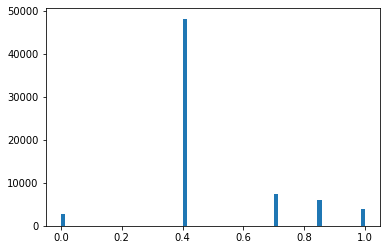

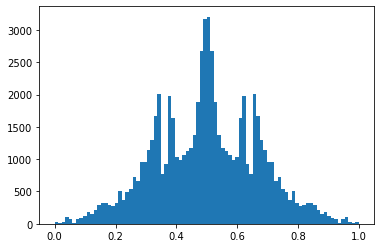

In [6]:
complete_images = images_complete + images_curves
complete_annotations = array_annotations_complete + array_annotations_curves

print('--- COMPLETE DATASET ---')
ann_x = []
ann_y = []
for ann in complete_annotations:
    ann_x.append(ann[0])
    ann_y.append(ann[1])

n, bins, patches = plt.hist(x=ann_x, bins='auto')
plt.show()
n, bins, patches = plt.hist(x=ann_y, bins='auto')
plt.show()

In [7]:
split_test_train_value = 0.30
images_train, images_validation, annotations_train, annotations_validation = train_test_split(complete_images, complete_annotations, test_size=split_test_train_value, random_state=42, shuffle=True)

# Adapt the data
images_train = np.stack(images_train, axis=0)
annotations_train = np.stack(annotations_train, axis=0)
images_validation = np.stack(images_validation, axis=0)
annotations_validation = np.stack(annotations_validation, axis=0)

print(annotations_train[0])
print(annotations_train.shape)

#video = np.stack(array_imgs, axis=0)
print(images_train.shape)
print(images_validation.shape)

[1.         0.52855172]
(47672, 2)
(47672, 60, 160, 3)
(20432, 60, 160, 3)


In [8]:
from tensorflow.keras.utils import Sequence
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import math

class DatasetSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, augmentations):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]

        return np.stack([
            self.augment(image=x)["image"] for x in batch_x
        ], axis=0), np.array(batch_y)

--- ANNOTATIONS DATA ---


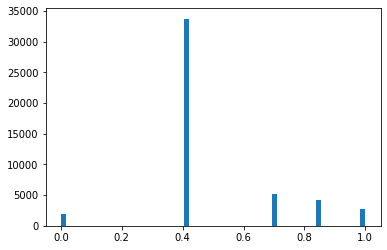

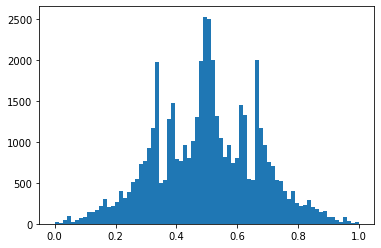

--- VALIDATION DATA ---


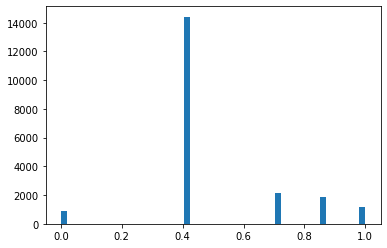

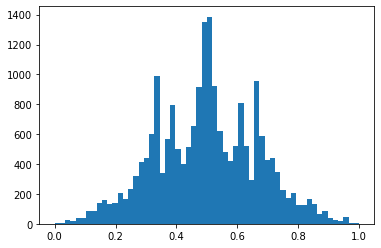

In [9]:
print('--- ANNOTATIONS DATA ---')
ann_x = []
ann_y = []
for ann in annotations_train:
    ann_x.append(ann[0])
    ann_y.append(ann[1])

n, bins, patches = plt.hist(x=ann_x, bins='auto')
plt.show()
n, bins, patches = plt.hist(x=ann_y, bins='auto')
plt.show()

print('--- VALIDATION DATA ---')
ann_x = []
ann_y = []
for ann in annotations_validation:
    ann_x.append(ann[0])
    ann_y.append(ann[1])

n, bins, patches = plt.hist(x=ann_x, bins='auto')
plt.show()
n, bins, patches = plt.hist(x=ann_y, bins='auto')
plt.show()

In [10]:

from albumentations import (
    Compose, HorizontalFlip, RandomBrightnessContrast, 
    HueSaturationValue, FancyPCA, RandomGamma, GaussNoise,
    GaussianBlur, ToFloat, Normalize
)

AUGMENTATIONS_TRAIN = Compose([
    RandomBrightnessContrast(),
    HueSaturationValue(),
    FancyPCA(),
    RandomGamma(),
    GaussianBlur(),
    GaussNoise(),
    Normalize()
])

AUGMENTATIONS_TEST = Compose([
    Normalize()
])


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, BatchNormalization, Dropout, ConvLSTM2D, Reshape, Activation, MaxPooling2D
from tensorflow.keras.optimizers import Adam


def pilotnet_model(img_shape):
    '''
    Model of End to End Learning for Self-Driving Cars (NVIDIA)
    '''
    model = Sequential()
    model.add(BatchNormalization(epsilon=0.001, axis=-1, input_shape=img_shape))
    model.add(Conv2D(24, (5, 5), strides=(2, 2), activation="relu",padding='same'))
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation="relu",padding='same'))
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation="relu",padding='same'))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu",padding='same'))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu",padding='same'))
    model.add(Flatten())
    model.add(Dense(1164, activation="relu"))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(50, activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(2))
    adam = Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss="mse", metrics=['mse', 'mae'])
    return model

In [ ]:
import time
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, CSVLogger
import datetime

timestr = time.strftime("%Y%m%d-%H%M%S")
print(timestr)
img_shape = (60, 160, 3)

hparams = {
    'train_batch_size': 50, 
    'val_batch_size': 50,
    'batch_size': 50,
    'n_epochs': 100, 
    'checkpoint_dir': 'logs_test/'
}

print(hparams)

model_name = 'pilotnet_model'
model = pilotnet_model(img_shape)
model_filename = timestr + '_pilotnet_model_100_complete_n_curves_all_albumentations'
model_file = model_filename + '.h5'


# Training data
train_gen = DatasetSequence(images_train, annotations_train, hparams['batch_size'], augmentations=AUGMENTATIONS_TRAIN)

# Validation data
valid_gen = DatasetSequence(images_validation, annotations_validation, hparams['batch_size'], augmentations=AUGMENTATIONS_TEST)


# Define callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystopping=EarlyStopping(monitor="mae", patience=30, verbose=1, mode='auto')
# Create a callback that saves the model's weights
checkpoint_path = model_filename + '_cp.h5'
cp_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='mse', save_best_only=True, verbose=1)
csv_logger = CSVLogger(model_filename + '.csv', append=True)

# Print layers
print(model)
model.build(img_shape)
print(model.summary())
# Training
model.fit(
    train_gen,
    epochs=hparams['n_epochs'],
    verbose=2,
    validation_data=valid_gen,
    #workers=2, use_multiprocessing=False,
    callbacks=[tensorboard_callback, earlystopping, cp_callback, csv_logger])

# Save the model
model.save(model_file)


# Evaluate the model
score = model.evaluate_generator(valid_gen, verbose=0)

print('Evaluating')
print('Test loss: ', score[0])
print('Test mean squared error: ', score[1])
print('Test mean absolute error: ', score[2])


# SAVE METADATA
from tensorflow.python.keras.saving import hdf5_format
import h5py

model_path = model_file
# Save model
with h5py.File(model_path, mode='w') as f:
    hdf5_format.save_model_to_hdf5(model, f)
    f.attrs['experiment_name'] = ''
    f.attrs['experiment_description'] = ''
    f.attrs['batch_size'] = hparams['train_batch_size']
    f.attrs['nb_epoch'] = hparams['n_epochs']
    f.attrs['model'] = model_name
    f.attrs['img_shape'] = img_shape
    f.attrs['normalized_dataset'] = True
    f.attrs['sequences_dataset'] = True
    f.attrs['gpu_trained'] = True
    f.attrs['data_augmentation'] = True
    f.attrs['extreme_data'] = False
    f.attrs['split_test_train'] = 0.30
    f.attrs['instances_number'] = len(array_annotations_train)
    f.attrs['loss'] = score[0]
    f.attrs['mse'] = score[1]
    f.attrs['mae'] = score[2]
    f.attrs['csv_path'] = model_filename + '.csv'

20210702-072336
{'train_batch_size': 50, 'val_batch_size': 50, 'batch_size': 50, 'n_epochs': 100, 'checkpoint_dir': 'logs_test/'}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 60, 160, 3)        12        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 80, 24)        1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 40, 36)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 20, 48)         43248     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 20, 64)         27712     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 20, 64)         3